In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import os

## Load Data

In [5]:
dtp = pd.read_csv(os.path.join('data', 'MSK_DTP_highway_features.csv'), encoding='utf-8', sep=',')
dtp['target'] = 1
#dtp = dtp.rename(columns={"X": "bump_Dista", "Y": "bump_Distance"})
dtp.shape
dtp['Longitude'] = dtp['point'].str.split(',', 1, expand=True)[1].str.replace(' "long": ', '').str.replace(' }', '')
dtp['Latitude'] = dtp['point'].str.split(',', 1, expand=True)[0].str.replace('{ "lat": ', '')

In [168]:
#dtp = dtp[(dtp['dead_count']>0)]

In [6]:
no_dtp = pd.read_csv(os.path.join('data', 'MSK_random+фичи.csv'), encoding='utf-8', sep=',')
no_dtp['target'] = 0
print(no_dtp.shape)
#Удалим, если на расстоянии 50 метров были смертельные ДТП и если на расстоянии 10 метров были вообще ДТП
no_dtp = no_dtp[(no_dtp['50dead_Num']==0)&(no_dtp['NUM_10NOND']==0)]
no_dtp = no_dtp.rename(columns={"x": "Longitude", "y": "Latitude"})
print('After filter', no_dtp.shape)

(3248, 45)
After filter (3230, 45)


In [7]:
set(no_dtp.columns).difference(dtp.columns)

{'10dead_NUM',
 '50dead_Num',
 '50notdead_',
 'NUM_10NOND',
 'xcoord_bad',
 'y_coord_bad'}

In [8]:
same_cols = set(no_dtp.columns).intersection(dtp.columns)
#same_cols.difference_update(['join_max_1','join_area','join_int_r'])

In [9]:
data_all = pd.concat([no_dtp[same_cols], dtp[same_cols]], axis=0)
data_all.shape

(9705, 39)

In [11]:
#Look for features
less_dict = {}
more_dict = {}
for col in data_all.columns:
    t = set(data_all[col])
    if len(t)<20:
        less_dict[col] = t
    else:
        more_dict[col] = t
for k, v in less_dict.items():
    print(k,v)
print('')    
for k, v in more_dict.items():
    print(k,'len: ',len(v))

join_t_lanes {0, 1, 2, 3, 4}
join_btf {0, 1, 2, 3, 6, 7, 8, 9, 10, 16}
join_t_sidewalk {0, 1, 2, 3, 4, 5, 8}
join_bicyclanes {0, 1, 2, 3}
join_f_buslanes {0, 1}
join_multidigit {0, 1}
join_f_sidewalk {0, 1, 2, 3, 4, 5, 8}
join_f_parking {0, 1, 2, 3, 4, 5, 6}
join_nlevel {1, 2, 3, 4, 6, 7}
join_splitter {0, 1, 2, 3, 4}
join_t_buslanes {0, 1}
join_speedlim {130, 100, 5, 40, 10, 77, 110, 80, 50, 20, 90, 60, 30}
join_t_rspeed {0, 5, 40, 15, 20, 25, 60}
join_f_lanes {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
join_f_rspeed {5, 40, 75, 15, 50, 20, 25, 60, 30}
join_t_parking {0, 1, 3, 4, 5, 6}
join_typ_cod {7730, 7706, 7700, 7701, 7702, 7703, 7770, 7740}
join_surface {1, 2, 3, 4, 5, 6, 7, 9}
join_oneway {0, 1, 2}
join_lanewidth {0}
target {0, 1}
join_rd_e_name {nan, 'Е105', 'Е30'}

Cros_HubDist len:  8970
Stop_HubName len:  2639
Stop_HubDist len:  8970
id len:  9705
Cros_HubName len:  5962
Bump_HubDist len:  8970
join_rd_l_name len:  24
Longitude len:  9107
join_rd_name len:  1483
Bump_HubName len:  344
j

In [12]:
data_all = data_all.reset_index().drop(columns = ['index'])

In [15]:
#Nominal features
nominal_columns = ['join_typ_cod', 'join_oneway', 'join_surface', 'join_f_parking', 'join_t_parking', 'join_bicyclanes'
                   , 'join_btf'
                  ]
for n_col in nominal_columns:
    data_all[n_col] = data_all[n_col].fillna('default')
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(data_all[nominal_columns]).toarray()
feature_labels = ohe.categories_
feature_cols = []
for i in range(len(nominal_columns)):
    for sub_col in feature_labels[i]:
        feature_cols.append(nominal_columns[i]+'__'+str(sub_col))
data_onehot = pd.DataFrame(feature_arr, columns = feature_cols)

In [16]:
# Final data select - with nominals
#digit_cols = ['stops_Dist','Crossing_D','join_lanes','Traf_lig_1', 'join_maxsp', 'bump_Dista']
digit_cols = [#'distance', 
 'Bump_HubDist', 'Cros_HubDist', 'traf_HubDist', 'Stop_HubDist']+\
['join_t_sidewalk', 'join_f_buslanes', 'join_speedlim', 
 'join_multidigit', 'join_f_sidewalk', 'join_f_rspeed', 'join_t_lanes', 
 'join_splitter', 'join_nlevel', 'join_t_rspeed', 'join_f_lanes', 'join_t_buslanes']

data = pd.concat([data_all, data_onehot], axis = 1)[digit_cols+feature_cols+['Latitude', 'Longitude', 'target']]

In [87]:
# Final data select - no nominals

#digit_cols = ['distance', 'Bump_HubDist', 'Cros_HubDist', 'traf_HubDist', 'Stop_HubDist']+\
#['join_t_sidewalk', 'join_f_buslanes', 'join_speedlim', 
# 'join_multidigit', 'join_f_sidewalk', 'join_f_rspeed', 'join_t_lanes', 
# 'join_splitter', 'join_nlevel', 'join_t_rspeed', 'join_f_lanes', 'join_t_buslanes']+\
#['join_btf', 'join_typ_cod', 'join_oneway', 'join_surface', 'join_f_parking', 'join_t_parking', 'join_bicyclanes']

#data = data_all[digit_cols+['Latitude', 'Longitude', 'target']]

In [17]:
data.shape

(9705, 65)

# Save data for cross check

In [19]:
#'Traf_lig_1', 
#       'join_onewa__default', 'join_onewa__no', 'join_onewa__yes',
#       'join_highw__primary', 'join_highw__secondary', 'join_highw__tertiary',
#       'join_highw__unclassified', 'Latitude', 'Longitude', 'target']
rename_columns = {
    'join_maxsp': 'join_speedlim',
    'bump_Dista': 'Bump_HubDist',
    'join_lanes': 'join_f_lanes',
    'stops_Dist':'Stop_HubDist',
    'Traf_lig_1': 'traf_HubDist',
    #join_surface :  0.019420441
    'Crossing_D': 'Cros_HubDist'
    #join_oneway :  0.08285009
    }
data_msk = data.rename(columns=rename_columns)[list(rename_columns.values())+['Latitude', 'Longitude', 'target']]
data_msk.to_csv(os.path.join('tmp', 'MSK_converted.csv'))

## Train

In [20]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [21]:
X, y_coord = data.iloc[:,:-3], data.iloc[:,-3:]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_coord, y_test_coord = train_test_split(X, y_coord, test_size=0.2, random_state=123)
y_train = y_train_coord.iloc[:, 2]
y_test = y_test_coord.iloc[:, 2]

In [23]:
# fit model no training data
models = {}
print('NB')
models['NB'] = GaussianNB()
models['NB'].fit(X_train, y_train)
print('xgb_train2')
models['xgb2'] = XGBClassifier(max_depth=2)
models['xgb2'].fit(X_train, y_train)
print('xgb_train3')
models['xgb3'] = XGBClassifier(max_depth=3)
models['xgb3'].fit(X_train, y_train)
print('xgb_train6')
models['xgb6'] = XGBClassifier(max_depth=6)
models['xgb6'].fit(X_train, y_train)
#print('svm')
#models['lin_svm'] = SVC(kernel="linear", C=0.025)
#models['lin_svm'].fit(X_train, y_train)


NB
xgb_train2
xgb_train3
xgb_train6


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
y_test_pred = {}
y_train_pred = {}
test_predicted_coord = [y_test_coord]
for model_name, model in models.items():
    y_test_pred[model_name] = model.predict(X_test)
    y_train_pred[model_name] = model.predict(X_train)
    test_predicted_coord.append(pd.DataFrame(model.predict_proba(X_test)[:,1], columns=[model_name]))
    accuracy = accuracy_score(y_test, y_test_pred[model_name])
    print(model_name)
    print("- accuracy test: %.2f%%" % (accuracy * 100.0))
    accuracy = accuracy_score(y_train, y_train_pred[model_name])
    print("- accuracy train: %.2f%%" % (accuracy * 100.0))   

NB
- accuracy test: 80.94%
- accuracy train: 80.09%
xgb2
- accuracy test: 86.09%
- accuracy train: 86.79%
xgb3
- accuracy test: 86.71%
- accuracy train: 88.99%
xgb6
- accuracy test: 86.04%
- accuracy train: 95.20%


__Save result__

In [25]:
all_cols = []
for i in range(len(test_predicted_coord)):
    print(test_predicted_coord[i].shape)
    all_cols+= list(test_predicted_coord[i].columns)
result = pd.DataFrame(np.concatenate(test_predicted_coord, axis=1), columns = all_cols)
result.to_csv(os.path.join('results', 'msk_predict_result.csv'))

(1941, 3)
(1941, 1)
(1941, 1)
(1941, 1)
(1941, 1)


# Explain

In [26]:
#Xgb feature importance
importance = []
for i in range(len(X.columns)):
    importance.append((X.columns[i], models['xgb2'].feature_importances_[i]))
importance.sort(key = lambda x: -x[1])
for item in importance:
    if item[1]>0:
        print(item[0], ': ', item[1])

join_typ_cod__7700 :  0.7467766
join_f_lanes :  0.044552073
join_f_sidewalk :  0.031373534
Cros_HubDist :  0.028981771
join_surface__2 :  0.02070396
join_t_sidewalk :  0.018023906
join_t_rspeed :  0.016977688
join_oneway__0 :  0.014250215
join_typ_cod__7730 :  0.012256463
join_f_rspeed :  0.010105382
join_btf__0 :  0.0095803905
join_surface__5 :  0.0061220187
join_surface__6 :  0.0051052975
Stop_HubDist :  0.0046074293
traf_HubDist :  0.0040027117
join_t_parking__1 :  0.0036715588
join_btf__8 :  0.0034827248
join_t_lanes :  0.0033358159
join_splitter :  0.0020174102
join_speedlim :  0.0020039002
join_typ_cod__7703 :  0.0019940888
Bump_HubDist :  0.0018426153
join_typ_cod__7702 :  0.001468776
join_f_parking__0 :  0.0014080219
join_nlevel :  0.0011403606
join_typ_cod__7740 :  0.0011044835
join_surface__4 :  0.0010714148
join_bicyclanes__3 :  0.0009954352
join_surface__7 :  0.00094011397
join_typ_cod__7701 :  0.0001039388


In [27]:
import shap

In [28]:
len(X_train)

7764

In [29]:
y_train[-10:]

4143    1
6782    1
6257    1
96      0
5857    1
7382    1
7763    1
5218    1
1346    0
3582    1
Name: target, dtype: int64

In [30]:
shap.initjs()
explainer = shap.TreeExplainer(models['xgb2'])
shap_values = explainer.shap_values(X_train)
i = 2766
print('Class: ', y_train.iloc[i])
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

Class:  1


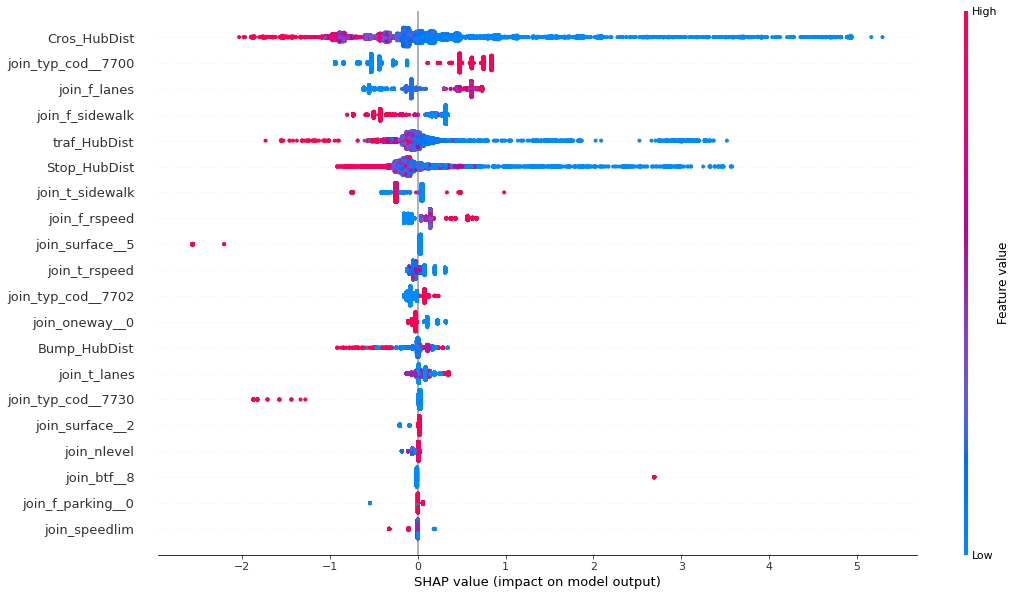

In [50]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_size=[17,10], show=False, )

import matplotlib.pyplot as pl
pl.savefig(os.path.join('results', "MSK_shap_summary_plot.jpg"))

# TSNE

In [51]:
from sklearn.manifold import TSNE

In [156]:
# Final data select - no nominals

digit_cols = ['distance', 'Bump_HubDist', 'Cros_HubDist', 'traf_HubDist', 'Stop_HubDist']+\
['join_t_sidewalk', 'join_f_buslanes', 'join_speedlim', 
 'join_multidigit', 'join_f_sidewalk', 'join_f_rspeed', 'join_t_lanes', 
 'join_splitter', 'join_nlevel', 'join_t_rspeed', 'join_f_lanes', 'join_t_buslanes']+\
['join_btf', 'join_typ_cod', 'join_oneway', 'join_surface', 'join_f_parking', 'join_t_parking', 'join_bicyclanes']


digit_cols = ['Bump_HubDist', 'Cros_HubDist', 'traf_HubDist', 'Stop_HubDist']
#['join_speedlim', 'join_multidigit', 'join_f_rspeed', 'join_t_lanes', 'join_splitter', 'join_nlevel', 'join_t_rspeed', 
# 'join_f_lanes']

data_tsne = data_all[digit_cols]
#data_tsne = data_tsne - np.mean(data_tsne)
#sigma = np.sqrt(np.square((data_tsne)).sum(axis=0))
#data_tsne = data_tsne/sigma
#data_tsne['y'] = data_all['target']

In [157]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(data_tsne)
print('t-SNE done!')

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 9705 samples in 0.020s...
[t-SNE] Computed neighbors for 9705 samples in 0.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9705
[t-SNE] Computed conditional probabilities for sample 2000 / 9705
[t-SNE] Computed conditional probabilities for sample 3000 / 9705
[t-SNE] Computed conditional probabilities for sample 4000 / 9705
[t-SNE] Computed conditional probabilities for sample 5000 / 9705
[t-SNE] Computed conditional probabilities for sample 6000 / 9705
[t-SNE] Computed conditional probabilities for sample 7000 / 9705
[t-SNE] Computed conditional probabilities for sample 8000 / 9705
[t-SNE] Computed conditional probabilities for sample 9000 / 9705
[t-SNE] Computed conditional probabilities for sample 9705 / 9705
[t-SNE] Mean sigma: 34.150538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.585663
[t-SNE] KL divergence after 300 iterations: 1.764288
t-SNE done!


In [168]:
import matplotlib.pyplot as plt
import seaborn as sns


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


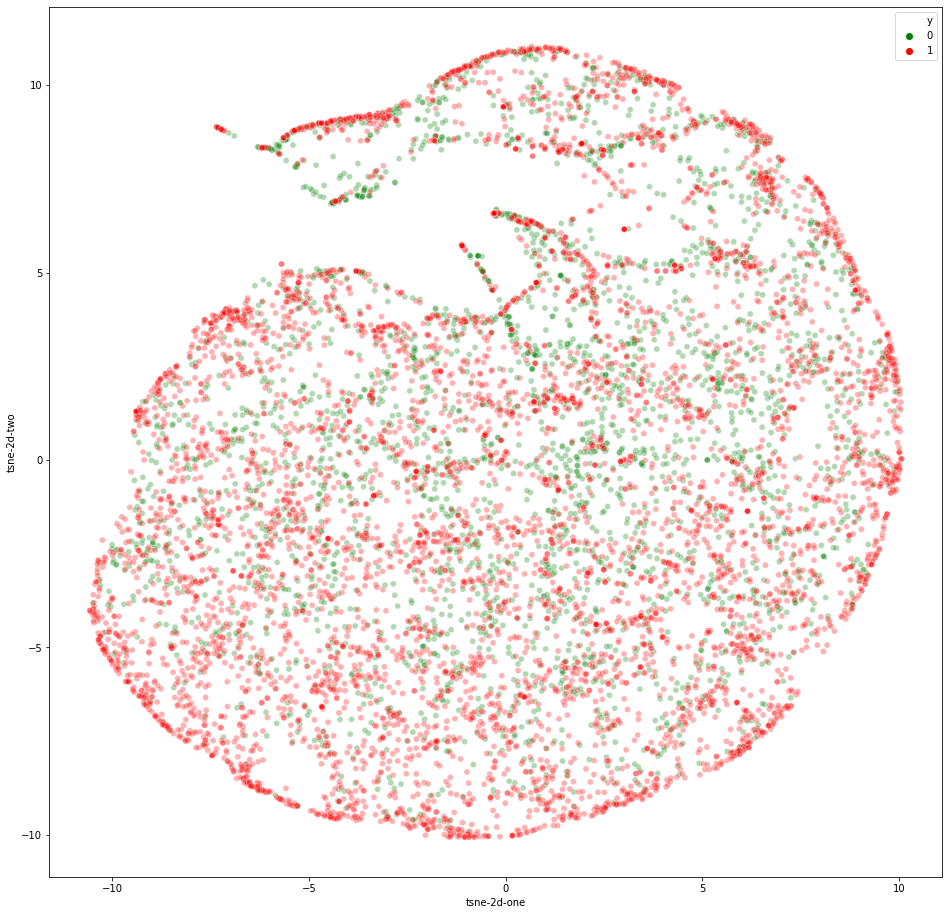

In [169]:
data_tsne['tsne-2d-one'] = tsne_results[:,0]
data_tsne['tsne-2d-two'] = tsne_results[:,1]
data_tsne['y'] = data_all['target']
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=['g','r'], # sns.color_palette("hls", 2),
    data=data_tsne,
    legend="full",
    alpha=0.3
)